In [ ]:
import numpy as np
import pandas as pd
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import cufflinks as cf
from plotly.offline import init_notebook_mode, iplot
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Initialize notebook mode for Plotly
init_notebook_mode(connected=True)
cf.go_offline()

# Initialize Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))

# Preprocess review text
def preprocess_text(text):
    if isinstance(text, str):
        text = re.sub("[^a-zA-Z ]", '', text)
        text = text.lower().strip()
        return text
    else:
        return ''

# Sentiment analysis using VADER
def vader_sentiment_analysis(text):
    score = analyzer.polarity_scores(text)
    compound = score['compound']
    if compound >= 0.7:
        return 'Very Positive'
    elif compound >= 0.3:
        return 'Positive'
    elif compound > -0.3:
        return 'Neutral'
    elif compound > -0.7:
        return 'Negative'
    else:
        return 'Very Negative'

# Aspect-based sentiment analysis
def aspect_sentiment_analysis(text):
    aspects = ['quality', 'price', 'delivery', 'customer service']  # Example aspects
    aspect_sentiments = {aspect: [] for aspect in aspects}
    
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]
    
    for aspect in aspects:
        if aspect in tokens:
            aspect_indices = [i for i, token in enumerate(tokens) if token == aspect]
            for idx in aspect_indices:
                if idx > 0 and idx < len(tokens) - 1:
                    left_word = tokens[idx - 1]
                    right_word = tokens[idx + 1]
                    aspect_sentiment = None
                    if left_word in ['good', 'excellent']:
                        aspect_sentiment = 'Positive'
                    elif left_word in ['poor', 'bad']:
                        aspect_sentiment = 'Negative'
                    elif right_word in ['good', 'excellent']:
                        aspect_sentiment = 'Positive'
                    elif right_word in ['poor', 'bad']:
                        aspect_sentiment = 'Negative'
                    if aspect_sentiment:
                        aspect_sentiments[aspect].append(aspect_sentiment)
    
    return aspect_sentiments

# Fake review detection enhanced for single review
def detect_fake_review_single(review_text):
    review_length = len(review_text.split())

    # Check overly positive
    positive_words = ['excellent', 'awesome', 'fantastic', 'amazing', 'great', 'love']
    overly_positive = any(word in review_text for word in positive_words)

    # Check short reviews
    short_review = review_length < 5

    # Highly generic reviews
    highly_generic = len(set(review_text.split())) < 3

    # Assume no duplicate content and no burst for single review input
    duplicate_content = False
    review_burst = False

    # Define potential fake based on flags
    potential_fake = overly_positive or short_review or highly_generic or duplicate_content or review_burst
    
    return potential_fake

# Apply fake review detection for entire dataset
def detect_fake_reviews_enhanced(df):
    df['review_length'] = df['reviewText'].apply(lambda x: len(x.split()))

    # Overly positive reviews
    positive_words = ['excellent', 'awesome', 'fantastic', 'amazing', 'great', 'love']
    df['overly_positive'] = df['reviewText'].apply(lambda x: any(word in x for word in positive_words))

    # Short reviews
    df['short_review'] = df['review_length'] < 5

    # Highly generic reviews
    df['highly_generic'] = df['reviewText'].apply(lambda x: len(set(x.split())) < 3)

    # Define potential fake review
    df['potential_fake'] = np.where(
        df['overly_positive'] | df['short_review'] | df['highly_generic'],
        True,
        False
    )
    
    return df

# Plot aspect sentiments for the entire dataset
def plot_aspect_sentiments(df):
    aspects = ['quality', 'price', 'delivery', 'customer service']
    aspect_counts = {aspect: {'Positive': 0, 'Negative': 0} for aspect in aspects}
    
    for aspect_sentiments in df['aspect_sentiments']:
        for aspect, sentiments in aspect_sentiments.items():
            for sentiment in sentiments:
                aspect_counts[aspect][sentiment] += 1
    
    aspect_df = pd.DataFrame(aspect_counts)
    aspect_df.plot(kind='bar', stacked=True)
    plt.title('Aspect-based Sentiment Analysis')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Plot potential fake reviews for the dataset
def plot_potential_fake_reviews(df):
    plt.figure(figsize=(6, 4))
    sns.countplot(x='potential_fake', data=df)
    plt.title('Potential Fake Reviews')
    plt.xlabel('Is Potential Fake')
    plt.ylabel('Count')
    plt.show()

# Function to process dataset and visualize results
def analyze_dataset(df):
    # Preprocess review text
    df['reviewText'] = df['reviewText'].map(preprocess_text)

    # Apply VADER sentiment analysis
    df['vader_sentiment'] = df['reviewText'].apply(vader_sentiment_analysis)

    # Apply aspect-based sentiment analysis
    df['aspect_sentiments'] = df['reviewText'].apply(aspect_sentiment_analysis)

    # Apply fake review detection
    df = detect_fake_reviews_enhanced(df)
    
    # Plot sentiment distribution
    categorical_variable_summary(df, 'vader_sentiment')
    
    # Plot aspect-based sentiment analysis
    plot_aspect_sentiments(df)
    
    # Plot potential fake reviews
    plot_potential_fake_reviews(df)

# Visualizing sentiment distribution of the dataset
def categorical_variable_summary(df, column_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentage'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])
    fig.add_trace(go.Bar(y=df[column_name].value_counts().values.tolist(),
                         x=[str(i) for i in df[column_name].value_counts().index],
                         text=df[column_name].value_counts().values.tolist(),
                         textfont=dict(size=14),
                         name=column_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=['#FF4136', '#FF851B', '#FFDC00', '#2ECC40', '#0074D9'],
                                     line=dict(color='#DBE6EC', width=1))),
                  row=1, col=1)
    fig.add_trace(go.Pie(labels=df[column_name].value_counts().keys(),
                         values=df[column_name].value_counts().values,
                         textfont=dict(size=18),
                         textposition='auto',
                         showlegend=False,
                         name=column_name,
                         marker=dict(colors=['#FF4136', '#FF851B', '#FFDC00', '#2ECC40', '#0074D9'])),
                  row=1, col=2)
    fig.update_layout(title={'text': column_name,
                             'y':0.9,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                     template='plotly_white')
    iplot(fig)

# Function to analyze a single review
def analyze_single_review(review_text):
    # Process the review
    review_text_processed = preprocess_text(review_text)
    
    # Sentiment analysis
    vader_sentiment = vader_sentiment_analysis(review_text_processed)
    
    # Aspect-based sentiment analysis
    aspect_sentiments = aspect_sentiment_analysis(review_text_processed)
    
    # Fake review detection
    potential_fake = detect_fake_review_single(review_text_processed)
    
    # Display results
    print("\n*** Review Analysis Results ***")
    print(f"Review: {review_text}")
    print(f"VADER Sentiment: {vader_sentiment}")
    print(f"Aspect Sentiments: {aspect_sentiments}")
    print(f"Potential Fake Review: {'Yes' if potential_fake else 'No'}")

# Example dataset usage (assuming you have a dataset loaded as 'df')
df = pd.read_csv("amazon.csv")

# Run the analysis on the dataset
analyze_dataset(df)

# Function to take real-time input for review analysis
def input_review_data():
    while True:
        review_text = input("Enter review text (or 'exit' to quit): ")
        if review_text.lower() == 'exit':
            break
        analyze_single_review(review_text)

# Prompt for real-time review analysis
input_review_data()


Sentiment Distribution:
 vader_sentiment
Very Positive    1903
Positive         1382
Neutral          1040
Negative          411
Very Negative     179
Name: count, dtype: int64


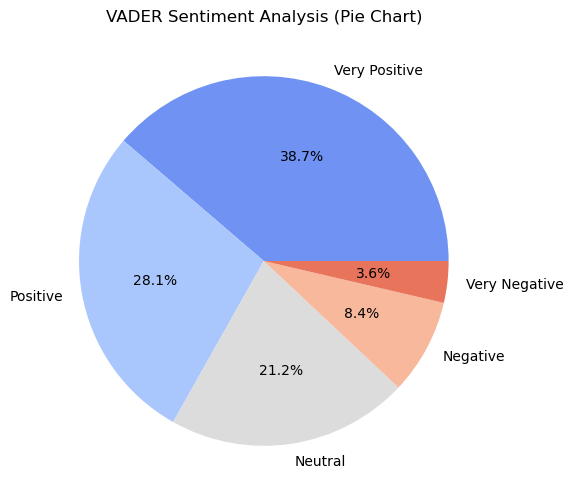

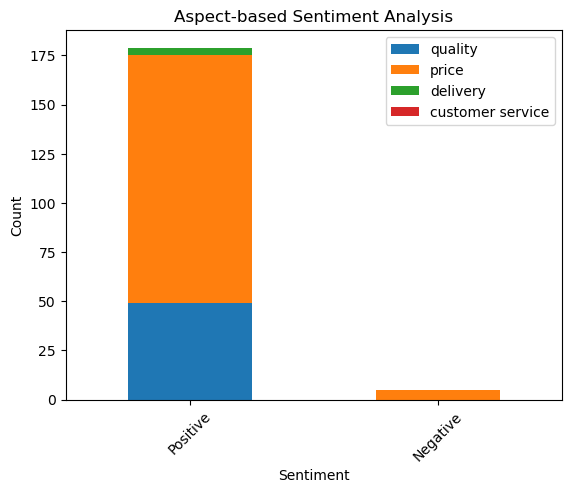

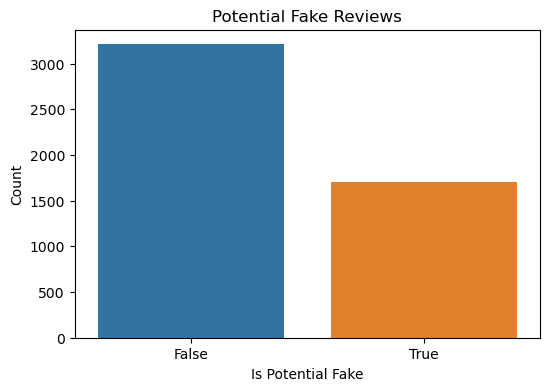

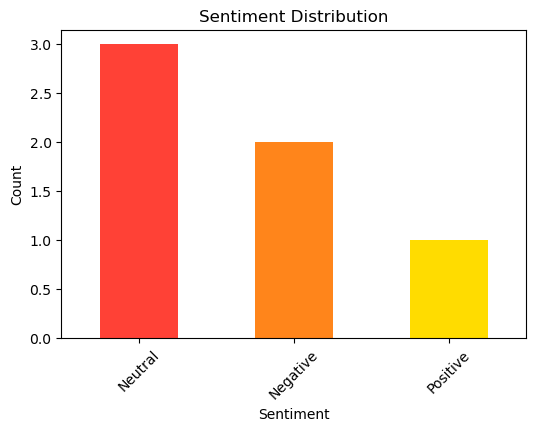

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import cufflinks as cf
from plotly.offline import init_notebook_mode, iplot
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings
import tkinter as tk
from tkinter import scrolledtext, messagebox
import matplotlib.pyplot as plt

# Ignore warnings
warnings.filterwarnings("ignore")

# Initialize notebook mode for Plotly
init_notebook_mode(connected=True)
cf.go_offline()

# Initialize Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))

# Preprocess review text
def preprocess_text(text):
    if isinstance(text, str):
        text = re.sub("[^a-zA-Z ]", '', text)
        text = text.lower().strip()
        return text
    else:
        return ''

# Sentiment analysis using VADER
def vader_sentiment_analysis(text):
    score = analyzer.polarity_scores(text)
    compound = score['compound']
    if compound >= 0.7:
        return 'Very Positive'
    elif compound >= 0.3:
        return 'Positive'
    elif compound > -0.3:
        return 'Neutral'
    elif compound > -0.7:
        return 'Negative'
    else:
        return 'Very Negative'

# Aspect-based sentiment analysis
def aspect_sentiment_analysis(text):
    aspects = ['quality', 'price', 'delivery', 'customer service']  # Example aspects
    aspect_sentiments = {aspect: [] for aspect in aspects}
    
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]
    
    for aspect in aspects:
        if aspect in tokens:
            aspect_indices = [i for i, token in enumerate(tokens) if token == aspect]
            for idx in aspect_indices:
                if idx > 0 and idx < len(tokens) - 1:
                    left_word = tokens[idx - 1]
                    right_word = tokens[idx + 1]
                    aspect_sentiment = None
                    if left_word in ['good', 'excellent']:
                        aspect_sentiment = 'Positive'
                    elif left_word in ['poor', 'bad']:
                        aspect_sentiment = 'Negative'
                    elif right_word in ['good', 'excellent']:
                        aspect_sentiment = 'Positive'
                    elif right_word in ['poor', 'bad']:
                        aspect_sentiment = 'Negative'
                    if aspect_sentiment:
                        aspect_sentiments[aspect].append(aspect_sentiment)
    
    return aspect_sentiments

# Fake review detection enhanced for single review
def detect_fake_review_single(review_text):
    review_length = len(review_text.split())

    # Check overly positive
    positive_words = ['excellent', 'awesome', 'fantastic', 'amazing', 'great', 'love']
    overly_positive = any(word in review_text for word in positive_words)

    # Check short reviews
    short_review = review_length < 5

    # Highly generic reviews
    highly_generic = len(set(review_text.split())) < 3

    # Define potential fake based on flags
    potential_fake = overly_positive or short_review or highly_generic
    
    return potential_fake

# Dataset visualizations remain intact
def plot_potential_fake_reviews(df):
    plt.figure(figsize=(6, 4))
    sns.countplot(x='potential_fake', data=df)
    plt.title('Potential Fake Reviews')
    plt.xlabel('Is Potential Fake')
    plt.ylabel('Count')
    plt.show()

def plot_aspect_sentiments(df):
    aspects = ['quality', 'price', 'delivery', 'customer service']  # Example aspects, add more as needed
    aspect_counts = {aspect: {'Positive': 0, 'Negative': 0} for aspect in aspects}
    
    for aspect_sentiments in df['aspect_sentiments']:
        for aspect, sentiments in aspect_sentiments.items():
            for sentiment in sentiments:
                aspect_counts[aspect][sentiment] += 1
    
    aspect_df = pd.DataFrame(aspect_counts)
    aspect_df.plot(kind='bar', stacked=True)
    plt.title('Aspect-based Sentiment Analysis')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Visualization for VADER sentiment analysis results as a pie chart
def plot_vader_sentiment_pie(df):
    sentiment_counts = df['vader_sentiment'].value_counts()
    labels = sentiment_counts.index
    sizes = sentiment_counts.values
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=sns.color_palette("coolwarm", len(labels)))
    ax.set_title('VADER Sentiment Analysis (Pie Chart)')
    plt.show()

# Create a Tkinter GUI for real-time input analysis
def create_gui():
    # Initialize the Tkinter window
    root = tk.Tk()
    root.title("Sentiment Analysis")

    # Set window size
    root.geometry("600x400")

    # Create and place a label
    label = tk.Label(root, text="Enter your review text (multiple statements separated by newlines):", font=("Arial", 14))
    label.pack(pady=10)

    # Create and place a text area for input
    text_area = scrolledtext.ScrolledText(root, wrap=tk.WORD, height=10)
    text_area.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)

    # Function to handle the analysis and display results
    def analyze_text():
        review_text = text_area.get("1.0", tk.END).strip()
        if not review_text:
            messagebox.showwarning("Input Error", "Please enter some text.")
            return
        
        # Split multiple statements by newline
        statements = [preprocess_text(stmt) for stmt in review_text.split("\n") if stmt.strip()]

        # Perform sentiment analysis on each statement
        sentiments = [vader_sentiment_analysis(stmt) for stmt in statements]

        # Count sentiment types
        sentiment_counts = pd.Series(sentiments).value_counts()

        # Visualize sentiment distribution
        visualize_sentiment_distribution(sentiment_counts)

    # Create and place an analyze button
    analyze_button = tk.Button(root, text="Analyze", command=analyze_text, font=("Arial", 12))
    analyze_button.pack(pady=10)

    # Function to visualize sentiment distribution
    def visualize_sentiment_distribution(sentiment_counts):
        plt.figure(figsize=(6, 4))
        sentiment_counts.plot(kind='bar', color=['#FF4136', '#FF851B', '#FFDC00', '#2ECC40', '#0074D9'])
        plt.title('Sentiment Distribution')
        plt.xlabel('Sentiment')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

    # Run the Tkinter event loop
    root.mainloop()

# Load the dataset
df = pd.read_csv("amazon.csv")

# Preprocess review text
df['reviewText'] = df['reviewText'].map(preprocess_text)

# Sentiment analysis using VADER
df['vader_sentiment'] = df['reviewText'].apply(vader_sentiment_analysis)

# Aspect-based sentiment analysis
df['aspect_sentiments'] = df['reviewText'].apply(aspect_sentiment_analysis)

# Detect potential fake reviews
df['potential_fake'] = df['reviewText'].apply(detect_fake_review_single)

# Dataset visualizations
def analyze_dataset(df):
    print("Sentiment Distribution:\n", df['vader_sentiment'].value_counts())
    plot_vader_sentiment_pie(df)  # Plot VADER sentiment as pie chart
    plot_aspect_sentiments(df)  # Plot aspect-based sentiment visualization
    plot_potential_fake_reviews(df)  # Plot fake review detection

# Analyze the dataset (to show the visualizations as requested)
analyze_dataset(df)

# Create the Tkinter interface for real-time text input
create_gui()


In [ ]:
+